# Pixel-based Area Preserving Distance Optimization
See https://cs.stackexchange.com/questions/133835/area-preserving-distance-optimization

(totally not optimized though)

In [1]:
%config Completer.use_jedi = False


In [2]:
import numpy as np
import PIL.Image


In [3]:
def parse_color(cstr):
    return int(cstr[1:3], 16), int(cstr[3:5], 16), int(cstr[5:7], 16)

COLORS = list(parse_color(c) for c in (
    "#FFFF00","#1CE6FF","#FF34FF","#FF4A46","#008941","#006FA6","#A30059","#FFDBE5","#7A4900","#0000A6",
    "#63FFAC","#B79762","#004D43","#8FB0FF","#997D87","#5A0007","#809693","#FEFFE6","#1B4400","#4FC601",
    "#3B5DFF","#4A3B53","#FF2F80","#61615A","#BA0900","#6B7900","#00C2A0","#FFAA92","#FF90C9","#B903AA",
    "#D16100","#DDEFFF","#000035","#7B4F4B","#A1C299","#300018","#0AA6D8","#013349","#00846F","#372101",
    "#FFB500","#C2FFED","#A079BF","#CC0744","#C0B9B2","#C2FF99","#001E09","#00489C","#6F0062","#0CBD66",
    "#EEC3FF","#456D75","#B77B68","#7A87A1","#788D66","#885578","#FAD09F","#FF8A9A","#D157A0","#BEC459",
    "#456648","#0086ED","#886F4C","#34362D","#B4A8BD","#00A6AA","#452C2C","#636375","#A3C8C9","#FF913F",
    "#938A81","#575329","#00FECF","#B05B6F","#8CD0FF","#3B9700","#04F757","#C8A1A1","#1E6E00","#7900D7",
    "#A77500","#6367A9","#A05837","#6B002C","#772600","#D790FF","#9B9700","#549E79","#FFF69F","#201625",
    "#72418F","#BC23FF","#99ADC0","#3A2465","#922329","#5B4534","#FDE8DC","#404E55","#0089A3","#CB7E98",
    "#A4E804","#324E72","#6A3A4C","#83AB58","#001C1E","#D1F7CE","#004B28","#C8D0F6","#A3A489","#806C66",
    "#222800","#BF5650","#E83000","#66796D","#DA007C","#FF1A59","#8ADBB4","#1E0200","#5B4E51","#C895C5",
    "#320033","#FF6832","#66E1D3","#CFCDAC","#D0AC94","#7ED379","#012C58","#7A7BFF","#D68E01","#353339",
    "#78AFA1","#FEB2C6","#75797C","#837393","#943A4D","#B5F4FF","#D2DCD5","#9556BD","#6A714A","#001325",
    "#02525F","#0AA3F7","#E98176","#DBD5DD","#5EBCD1","#3D4F44","#7E6405","#02684E","#962B75","#8D8546",
    "#9695C5","#E773CE","#D86A78","#3E89BE","#CA834E","#518A87","#5B113C","#55813B","#E704C4","#00005F",
    "#A97399","#4B8160","#59738A","#FF5DA7","#F7C9BF","#643127","#513A01","#6B94AA","#51A058","#A45B02",
    "#1D1702","#E20027","#E7AB63","#4C6001","#9C6966","#64547B","#97979E","#006A66","#391406","#F4D749",
    "#0045D2","#006C31","#DDB6D0","#7C6571","#9FB2A4","#00D891","#15A08A","#BC65E9","#FFFFFE","#C6DC99",
    "#203B3C","#671190","#6B3A64","#F5E1FF","#FFA0F2","#CCAA35","#374527","#8BB400","#797868","#C6005A",
    "#3B000A","#C86240","#29607C","#402334","#7D5A44","#CCB87C","#B88183","#AA5199","#B5D6C3","#A38469",
    "#9F94F0","#A74571","#B894A6","#71BB8C","#00B433","#789EC9","#6D80BA","#953F00","#5EFF03","#E4FFFC",
    "#1BE177","#BCB1E5","#76912F","#003109","#0060CD","#D20096","#895563","#29201D","#5B3213","#A76F42",
    "#89412E","#1A3A2A","#494B5A","#A88C85","#F4ABAA","#A3F3AB","#00C6C8","#EA8B66","#958A9F","#BDC9D2",
    "#9FA064","#BE4700","#658188","#83A485","#453C23","#47675D","#3A3F00","#061203","#DFFB71","#868E7E",
    "#98D058","#6C8F7D","#D7BFC2","#3C3E6E","#D83D66","#2F5D9B","#6C5E46","#D25B88","#5B656C","#00B57F",
    "#545C46","#866097","#365D25","#252F99","#00CCFF","#674E60","#FC009C","#92896B"
))


In [4]:
def random_seeds(num_pieces, width, height):
    seeds = set()
    while len(seeds) < num_pieces:
        seeds.add((np.random.randint(width), np.random.randint(height)))
    seeds = list(seeds)
    seed_matrix = np.full((width, height), -1, dtype=np.int32)
    for i, (x, y) in enumerate(seeds):
        seed_matrix[x, y] = i
    return seeds, seed_matrix


In [5]:
def initial_distribution(num_pieces, width, height):
    pixels = width * height
    assert pixels % num_pieces == 0
    
    distances = [(0, 0, 0, 0)]
    i = 1
    for y in range(0, height):
        for x in range(0, width):
            if y == 0 and x == 0:
                continue                
            dist2 = x**2 + y**2
            distances.append((dist2, i, x, y)); i += 1
            distances.append((dist2, i, x, -y)); i += 1
            distances.append((dist2, i, -x, -y)); i += 1
            distances.append((dist2, i, -x, y)); i += 1
            
    distances.sort()
        
    seeds, seed_matrix = random_seeds(num_pieces, width, height)
  
    result = np.full((width, height), -1, dtype=np.int32)
    
    dist_indices = [0] * num_pieces
    for c in range(width * height // num_pieces):
        for i, dist_index in enumerate(dist_indices):     
            x, y = seeds[i]
            di = dist_index
            while True:
                _, _, dx, dy = distances[di]          
                tx, ty = x + dx, y + dy
                if 0 <= tx < width and 0 <= ty < height and result[tx, ty] < 0:
                    result[tx, ty] = i
                    dist_indices[i] = di + 1
                    break
                di += 1
            
    return result, seeds, seed_matrix


In [6]:
def initial_random_distribution(num_pieces, width, height):
    pixels = width * height
    assert pixels % num_pieces == 0
       
    seeds, seed_matrix = random_seeds(num_pieces, width, height)

    result = np.repeat(range(num_pieces), width * height // num_pieces)
    np.random.shuffle(result) 
    result.resize(width, height)
   
    return result, seeds, seed_matrix
            

In [7]:
def optimize(values, seeds, iterations=10**8):
    for _ in range(iterations):
        x1, y1 = np.random.randint(values.shape[0]), np.random.randint(values.shape[1])
        x2, y2 = np.random.randint(values.shape[0]), np.random.randint(values.shape[1])
        v1 = values[x1, y1]
        v2 = values[x2, y2]
        s1x, s1y = seeds[v1]
        s2x, s2y = seeds[v2]
        if s1x == s2x and s1y == s2y:
            continue
        
        d1s1 = (x1 - s1x)**2 + (y1 - s1y)**2
        d1s2 = (x1 - s2x)**2 + (y1 - s2y)**2
        d2s1 = (x2 - s1x)**2 + (y2 - s1y)**2
        d2s2 = (x2 - s2x)**2 + (y2 - s2y)**2
        
        if d1s2 + d2s1 < d1s1 + d2s2:
            values[x1, y1], values[x2, y2] = v2, v1        
        

In [8]:
def render(values, scale=4):
    img = np.zeros((values.shape[0], values.shape[1], 3), dtype=np.uint8)
    for i in range(values.max()):
        img[values == i] = COLORS[i % len(COLORS)]
    img = PIL.Image.fromarray(img.transpose(1, 0, 2))
    return img.resize((img.width*scale, img.height*scale), PIL.Image.NEAREST)

# call render((seed_matrix == -1).astype(int) * result) to also highlight seed points


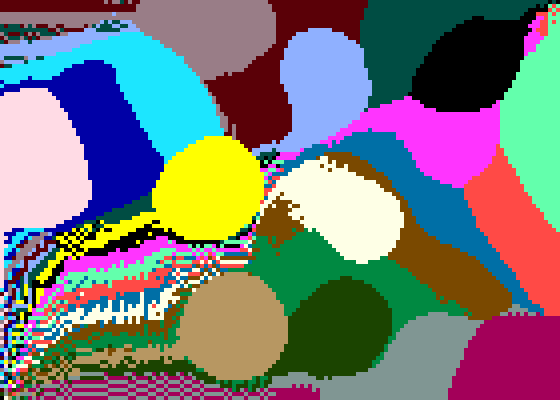

In [9]:
result, seeds, seed_matrix = initial_distribution(num_pieces=20, width=140, height=100)
render(result)


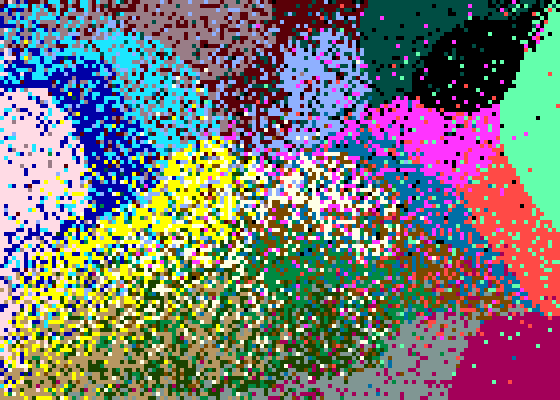

In [10]:
optimize(result, seeds, iterations=10**5)
render(result)

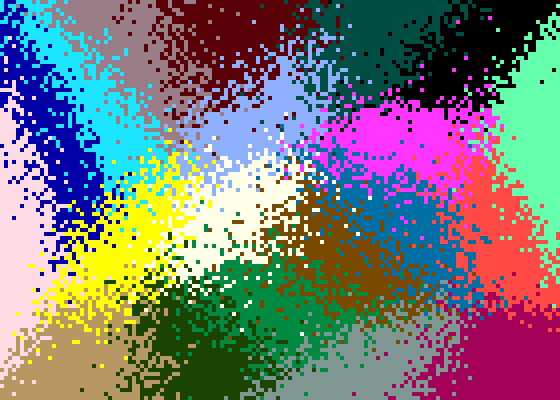

In [11]:
optimize(result, seeds, iterations=10**6)
render(result)

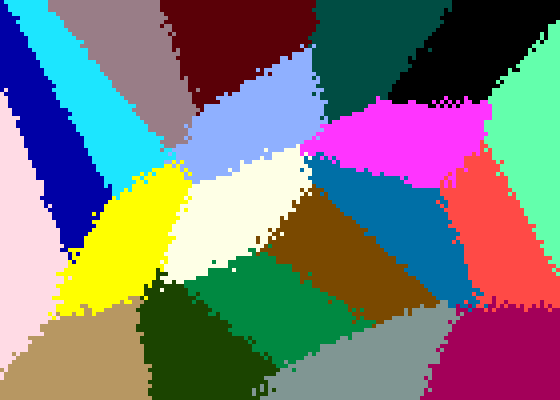

In [12]:
optimize(result, seeds, iterations=10**7)
render(result)

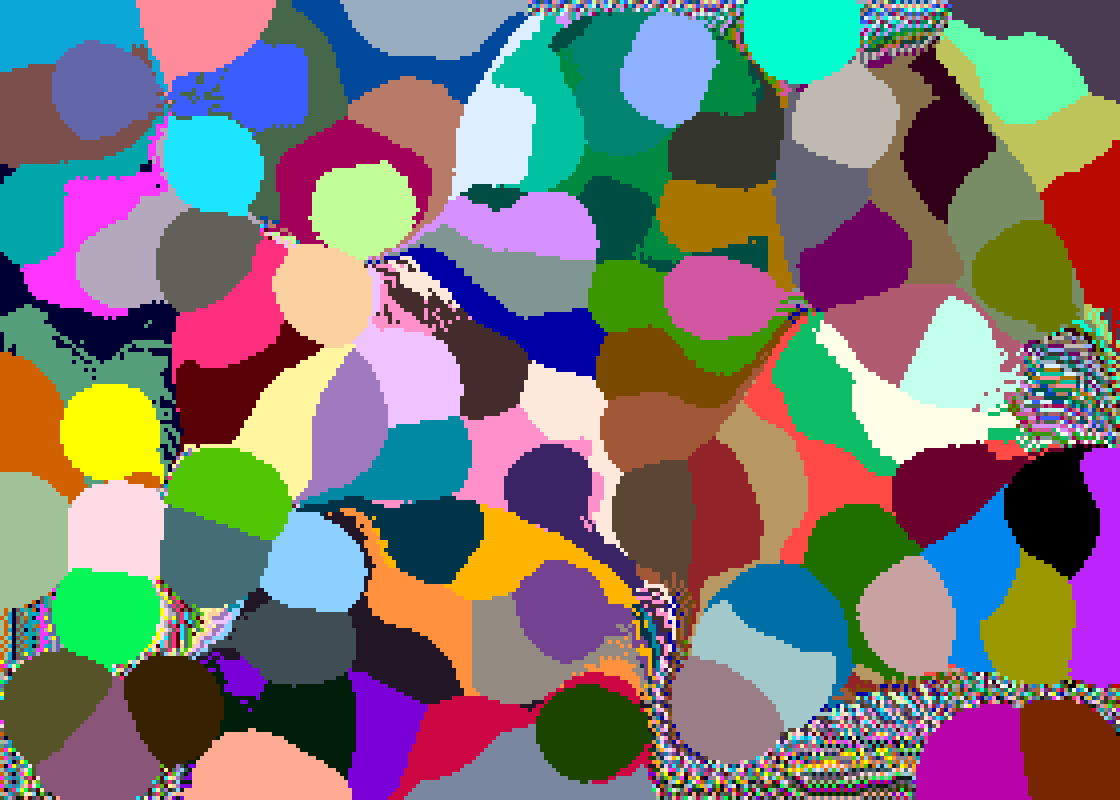

In [13]:
result, seeds, seed_matrix = initial_distribution(num_pieces=100, width=280, height=200)
render(result)

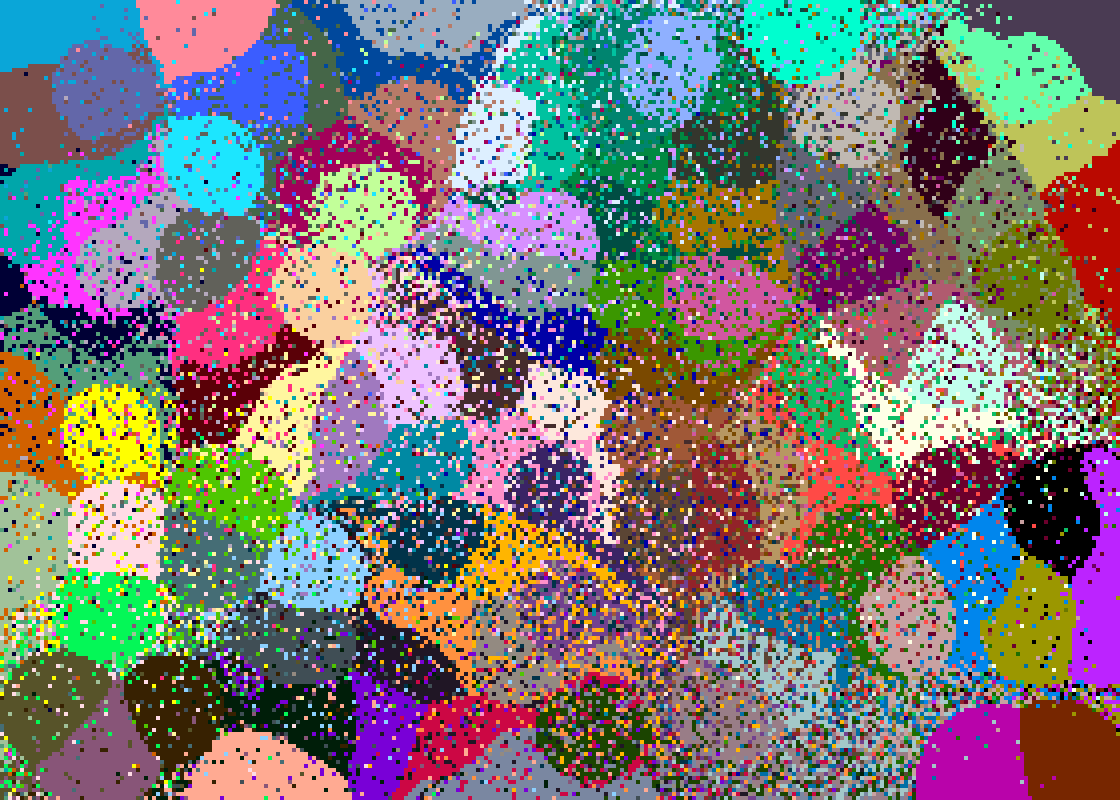

In [14]:
optimize(result, seeds, iterations=10**6)
render(result)

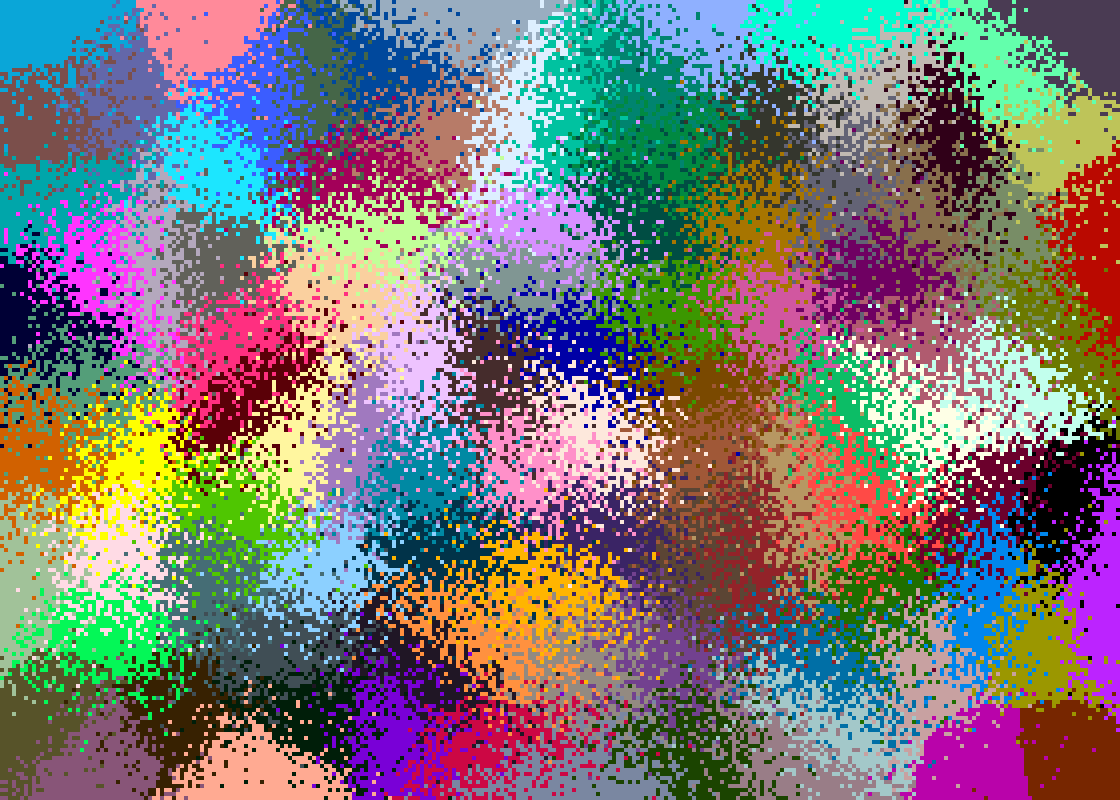

In [15]:
optimize(result, seeds, iterations=10**7)
render(result)

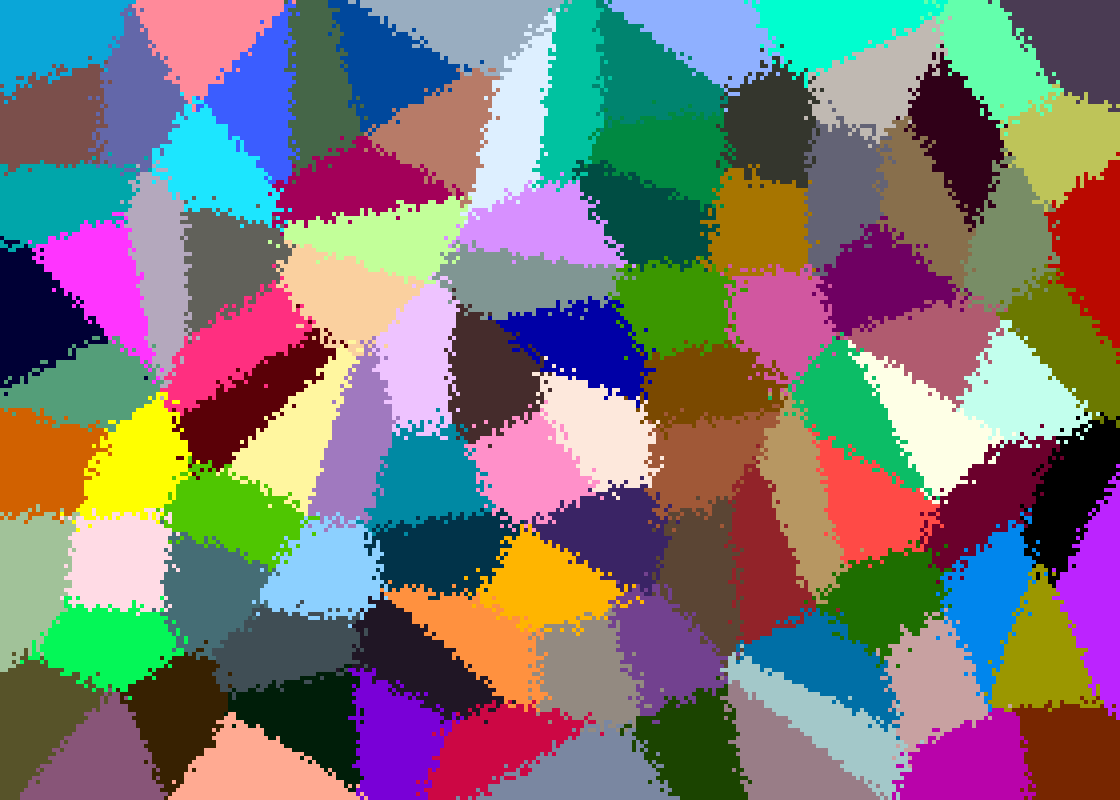

In [16]:
optimize(result, seeds, iterations=10**8)
render(result)

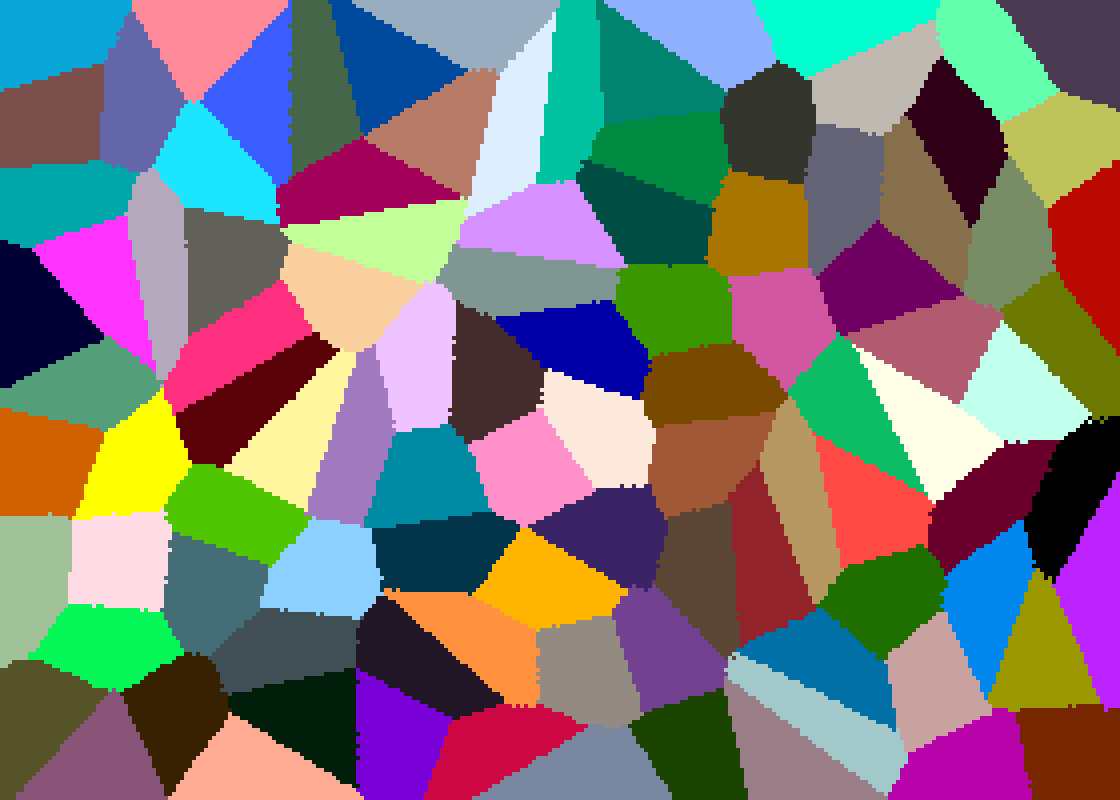

In [17]:
optimize(result, seeds, iterations=10**9)
render(result)
